In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event


In [5]:
mc_hits = mc_data.values

In [1]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r events

In [2]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [148]:
hits_total = mc_hits[mc_hits[:,13] < 17978]
print("Total hits with threshold %d" % (len(hits_total)))
event = 0
idx = {}
actual = 0
for hit in hits_total:
    if (not hit[13] in idx):
        p = index.Property()
        p.dimension = 3
        idx[hit[13]] = index.Index(properties=p, interleaved=False)
    
    if (len(hit[5]) > 1):
        for i in range(0,len(hit[5])):
            idx[hit[13]].insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), float(hit[5][i]))

Total hits with threshold 39483


In [297]:
X_tree_classifier = []
Y_tree_classifier = []
total = 0
mean_found = 0
mean_pos = 0
m_z = 1 / (zLays[3] - zLays[0])

for particle in hits_total:
    
    if (len(particle[5]) > 1):
        
        # Extract only 12 hits, as some of them are really close
        X_final = np.zeros(12)
        zone = particle[12][0]
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
            
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,2))[0][2])
        found = list(idx[particle[13]].intersection((predicted - long_range, predicted + long_range, 3, 3,zone,zone), objects='raw'))
        found = sorted(np.unique(found), key=lambda x: np.abs(x - predicted))[:20]
        
        for i in range(0,len(found)):
            if (found[i] == X_final[3]):
                mean_pos += i
                mean_found += 1
                X_tree_classifier.append([found[i], X_final[0],((found[i] - X_final[0]) * m_z), np.abs(found[i] - X_final[0])])
                Y_tree_classifier.append(1)
                if (i == 0):
                    if (i == len(found) - 1):
                        continue
                    X_tree_classifier.append([found[i + 1], X_final[0],((found[i + 1] - X_final[0]) * m_z),np.abs(found[i + 1] - X_final[0])])
                    Y_tree_classifier.append(0)
                    if (i + 2 < len(found)):
                        X_tree_classifier.append([found[i + 2], X_final[0],((found[i + 2] - X_final[0]) * m_z),np.abs(found[i + 2] - X_final[0])])
                        Y_tree_classifier.append(0)
                else:
                    if (i + 1 < len(found)):
                        X_tree_classifier.append([found[i + 1], X_final[0],((found[i + 1] - X_final[0]) * m_z), np.abs(found[i + 1] - X_final[0])])
                        Y_tree_classifier.append(0)
                    else:
                        X_tree_classifier.append([found[i - 2], X_final[0],((found[i - 2] - X_final[0]) * m_z), np.abs(found[i - 2] - X_final[0])])
                        Y_tree_classifier.append(0)
                    X_tree_classifier.append([found[i - 1], X_final[0],((found[i - 1] - X_final[0]) * m_z), np.abs(found[i - 1] - X_final[0])])
                    Y_tree_classifier.append(0)
                break
        total += 1

print("Mean found %f" % (mean_found/total))
print("Mean found %f" % (mean_pos/total))
print("Total %d" % total)

Mean found 0.952876
Mean found 3.184527
Total 15873


In [298]:
Y_plot = np.array(Y_tree_classifier).reshape(-1,1)
X_plot = np.array(X_tree_classifier).reshape(-1,4)

X_true = X_plot[Y_plot[:,0] == 1]
X_false = X_plot[Y_plot[:,0] == 0]

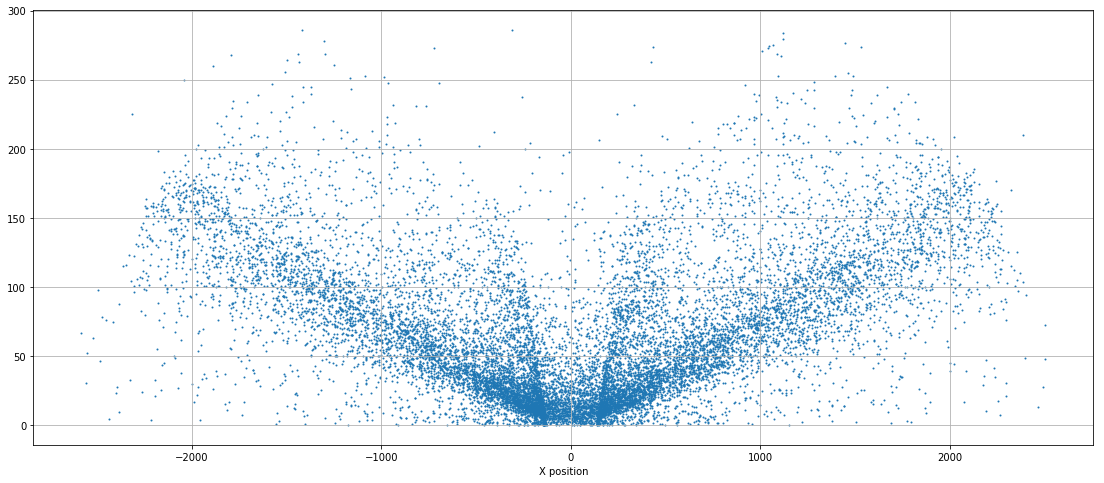

In [299]:
fig = plt.figure(figsize=(19, 8))

ax = fig.add_subplot(111)
ax.scatter(X_true[:,0], X_true[:,3],  s=1)
ax.set_xlabel('X position')
ax.grid()
plt.show()

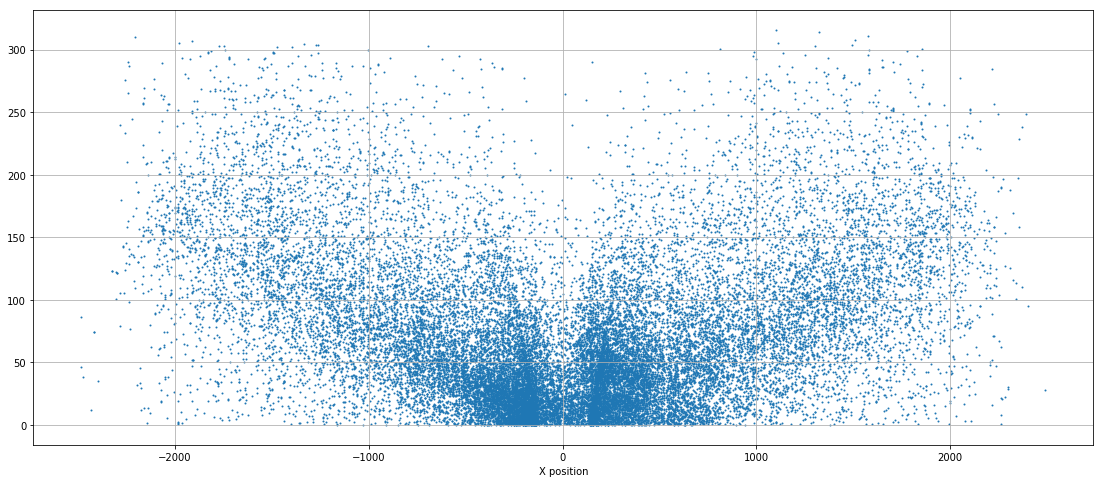

In [300]:
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
ax.scatter(X_false[:,0], X_false[:,3], s=1)
ax.set_xlabel('X position')
ax.grid()
plt.show()

In [289]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_tree_classifier), np.array(Y_tree_classifier))
print("X Train length: %d" % len(X_train))
print("X Test Length %d" % len(X_test))
print("Y Train length: %d" % len(y_train))
print("Y Test length: %d" % len(y_test))

X Train length: 33867
X Test Length 11290
Y Train length: 33867
Y Test length: 11290


In [290]:
train = xgb.DMatrix(data=np.array(X_train).reshape(-1,4),label=np.array(y_train).reshape(-1,1))
test = xgb.DMatrix(data=np.array(X_test).reshape(-1,4),label=np.array(y_test).reshape(-1,1))

In [291]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 20  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [292]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [293]:
print(booster.eval(test))

[0]	eval-error:0.364393	eval-logloss:0.631476	eval-rmse:0.471199


In [294]:
predictions = booster.predict(test)

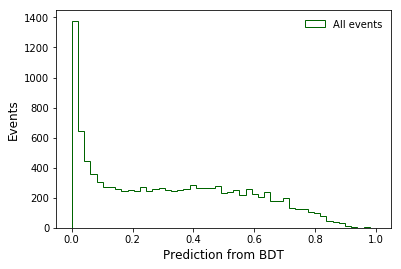

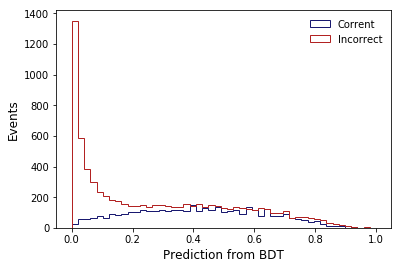

In [295]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Corrent');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Incorrect');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

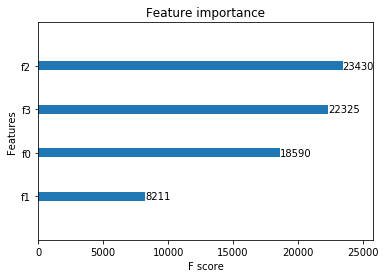

In [296]:
xgb.plot_importance(booster,grid=False);